In [1]:
%load_ext autoreload
%autoreload 2
import os, sys 
sys.path.append('../src')

In [9]:
from data_preprocessing import gee_utils as gu
from data_preprocessing import create_aux_data as cad
from data_preprocessing import data_utils as du

import geemap, ee 
import matplotlib.pyplot as plt
import pandas as pd

Generating URL ...
Please wait ...
Data downloaded to /Users/tplas/repos/aether/notebooks/tmp.tif


<function matplotlib.pyplot.colorbar(mappable: 'ScalarMappable | ColorizingArtist | None' = None, cax: 'matplotlib.axes.Axes | None' = None, ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None, **kwargs) -> 'Colorbar'>

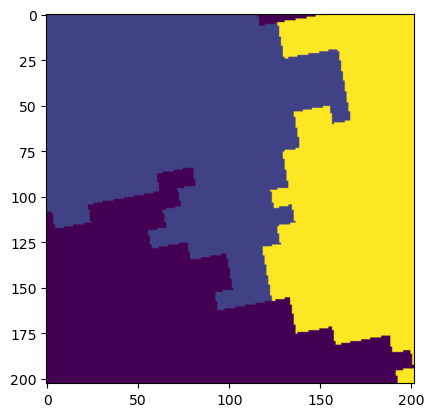

In [ ]:
tmp = gu.get_lc_from_coord(df_s2bms_presence.tuple_coords[0])
geemap.ee_export_image(
        tmp, filename='tmp.tif', 
        scale=10,  # 10m bands
        file_per_band=False,# crs='EPSG:32630'
    )
tmp_im = du.load_tiff('tmp.tif')
plt.imshow(tmp_im[0,...])
plt.colorbar

In [ ]:
## Create aux data set:
df_s2bms_presence = du.load_s2bms_presence()
cad.get_bioclim_lc_from_coords_list(coords_list=df_s2bms_presence.tuple_coords.values,
                                   name_list=df_s2bms_presence.name_loc.values,
                                   save_file=True, save_filename='s2bms_bioclim_lc_data.csv')

In [18]:
df_bioclim_lc = pd.read_csv('../data/source/butterflies/s2bms_bioclim_lc_data.csv')
corine_keys = [k for k in df_bioclim_lc.iloc[0].index if 'corine_frac_' in k]
df_bioclim_lc.iloc[0][corine_keys].sort_values()[-3:]
df_bioclim_lc[:3]

,bioclim_01,bioclim_02,bioclim_03,bioclim_04,bioclim_05,bioclim_06,bioclim_07,bioclim_08,bioclim_09,bioclim_10,...,corine_frac_421,corine_frac_422,corine_frac_423,corine_frac_511,corine_frac_512,corine_frac_521,corine_frac_522,corine_frac_523,coords,name
0,8.9,7.4,36.0,46.46,20.5,0.1,20.4,4.3,13.5,15.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-2.165105, 50.956811)",UKBMS_loc-0000
1,8.9,6.9,34.0,46.81,20.3,0.4,19.9,4.2,10.7,15.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-2.646667, 50.775285)",UKBMS_loc-0001
2,9.6,7.7,35.0,48.92,21.5,0.0,21.5,4.4,14.5,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-0.828484, 50.888106)",UKBMS_loc-0002


In [31]:
## rename columns:
df_bioclim_lc = pd.read_csv('../data/source/butterflies/s2bms_bioclim_lc_data.csv')
df_bioclim_lc.rename(columns={'name':'name_loc'}, inplace=True)
for c in df_bioclim_lc.columns:
    if c in ['name_loc']:
        continue
    df_bioclim_lc.rename(columns={c: f'aux_{c}'}, inplace=True)

df_s2bms_presence = du.load_s2bms_presence()
df_s2bms_presence.drop(columns=['geometry', 'n_visits'], inplace=True)
df_s2bms_presence.rename(columns={'tuple_coords':'coords'}, inplace=True)
for c in df_s2bms_presence.columns:
    if c in ['name_loc', 'lat', 'lon']:
        continue
    df_s2bms_presence.rename(columns={c: f'target_{c.replace(" ", "_")}'}, inplace=True)

df_merged = pd.merge(df_s2bms_presence, df_bioclim_lc, left_on='name_loc', right_on='name_loc', how='left')
print(df_merged[['aux_coords', 'target_coords']])
df_merged.drop(columns=['aux_coords', 'target_coords'], inplace=True)

columns_ordered = ['name_loc', 'lat', 'lon'] + \
    sorted([c for c in df_merged.columns if c not in ['name_loc', 'lat', 'lon']])
df_merged = df_merged[columns_ordered]
df_merged.head()
df_merged.to_csv('../data/model_ready/s2bms_presence_with_aux_data.csv', index=False)

                  aux_coords           target_coords
0     (-2.165105, 50.956811)  (-2.165105, 50.956811)
1     (-2.646667, 50.775285)  (-2.646667, 50.775285)
2     (-0.828484, 50.888106)  (-0.828484, 50.888106)
3      (-1.966038, 50.59722)   (-1.966038, 50.59722)
4     (-0.229941, 52.409243)  (-0.229941, 52.409243)
...                      ...                     ...
1324  (-0.751089, 51.651648)  (-0.751089, 51.651648)
1325  (-1.872219, 53.869641)  (-1.872219, 53.869641)
1326  (-1.619057, 53.275874)  (-1.619057, 53.275874)
1327  (-2.036753, 50.687147)  (-2.036753, 50.687147)
1328   (-5.19981, 55.598295)   (-5.19981, 55.598295)

[1329 rows x 2 columns]


In [32]:
pd.read_csv('../data/model_ready/s2bms_presence_with_aux_data.csv').head()

,name_loc,lat,lon,aux_bioclim_01,aux_bioclim_02,aux_bioclim_03,aux_bioclim_04,aux_bioclim_05,aux_bioclim_06,aux_bioclim_07,...,target_Quercusia,target_Satyrium_w,target_Speyeria_a,target_Thecla_bet,target_Thymelic_1,target_Thymelic_2,target_Thymelicus,target_Tyria_jaco,target_Vanessa_at,target_Vanessa_ca
0,UKBMS_loc-0000,50.956811,-2.165105,8.9,7.4,36.0,46.46,20.5,0.1,20.4,...,0.000000,0.0000,0.297872,0.0,0.255319,0.000000,0.063830,0.0,0.297872,0.212766
1,UKBMS_loc-0001,50.775285,-2.646667,8.9,6.9,34.0,46.81,20.3,0.4,19.9,...,0.033898,0.0000,0.025424,0.0,0.305085,0.000000,0.000000,0.0,0.271186,0.262712
2,UKBMS_loc-0002,50.888106,-0.828484,9.6,7.7,35.0,48.92,21.5,0.0,21.5,...,0.100000,0.0000,0.200000,0.0,0.300000,0.000000,0.000000,0.0,0.400000,0.000000
3,UKBMS_loc-0003,50.597220,-1.966038,10.0,7.6,38.0,43.71,21.0,1.3,19.7,...,0.000000,0.0000,0.106195,0.0,0.318584,0.283186,0.000000,0.0,0.469027,0.318584
4,UKBMS_loc-0004,52.409243,-0.229941,9.8,7.4,34.0,48.53,21.2,-0.1,21.3,...,0.104167,0.0625,0.000000,0.0,0.208333,0.000000,0.020833,0.0,0.312500,0.104167
